# Exponential Comparisons
step1: pds(emp power)
step2: theoretical exp. dist
step3: compare two distributions

In [1]:
#cd ..

In [2]:
import sys
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')

from scv_funcs import access_nt as asc
import numpy as np

In [8]:
#data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
session = 1
chan = [1,2,3,4] # start at 1

# with specified indices
indices = [0,0]
data = asc.get_ECoG(data_path, session, chan, indices)

In [9]:
import neurodsp as ndsp
import matplotlib.pyplot as plt
%matplotlib inline

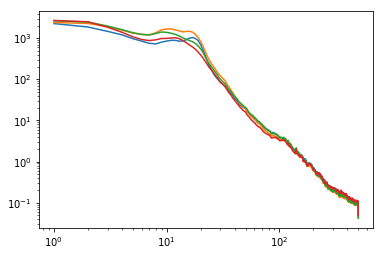

In [13]:
fs = 1000
nperseg = 1000
noverlap = nperseg/2
f, psd_ = ndsp.spectral.psd(data, Fs=fs, nperseg=nperseg, noverlap=noverlap)
#_, _, spg_ =
plt.loglog(f,psd_[0:,:].T);

In [14]:
sp.stats.expon.fit?

Object `sp.stats.expon.fit` not found.


Text(0.5,1,'Frequency=100.0 Hz')

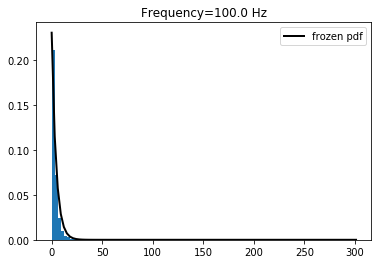

In [62]:
from scipy.stats import expon
import scipy as sp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = expon.stats(moments='mvsk')
y = np.arange(1,50)
#ax.plot(x, expon.pdf(x),'r-', lw=5, alpha=0.6, label='expon pdf')
#_ = ax.plot(psd_[0][:100])
# _ = ax.plot(psd_[1])

fs = 1000
nperseg = 1000
noverlap = 0
freq_ind = 100
num_bins = 100

#x, y, spg_ = sp.signal.spectrogram(data[0],fs=fs,nperseg=nperseg,noverlap=noverlap)
_, scale_ = sp.stats.expon.fit(spg_[freq_ind],floc=0)
hists = ax.hist(spg_[freq_ind],normed=True,bins=num_bins)
x = hists[1]
#x = np.linspace(0,500, 1000)
#ax.plot(x, expon.pdf(x),'r-', lw=5, label='expon pdf')
rv = expon(scale = scale_)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf',)
#plt.xlim(0,250)
#plt.ylim(0,0.0005)
plt.legend()
plt.title('Frequency=%.1f Hz' %f[freq_ind])

### KS statistic

In [65]:
def fit_exp_to_spg(spg_):
pvals = np.zeros((len(spg_)))
statistics = np.zeros((len(spg_)))

for i in range(len(spg_)):
    param = sp.stats.expon.fit(spg_[i], floc=0)
#    stat, pval = sp.stats.kstest(x, lambda x : sp.stats.expon.cdf(x, *param))
    stat, pval = sp.stats.kstest(spg_[i], 'expon', args=param)
    pvals[i] = pval
    statistics[i] = stat

In [67]:
spg_.shape

(501, 1929)

#### Plotting

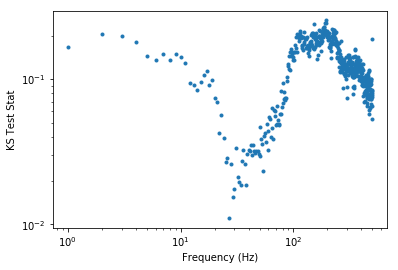

In [66]:
# expon
_ = plt.loglog(f, statistics,'.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('KS Test Stat');

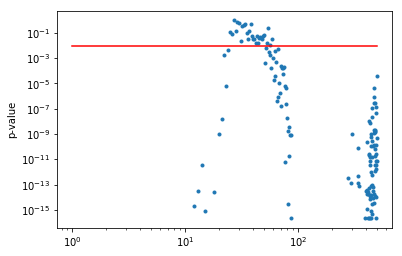

In [57]:
# expon
_ = plt.loglog(f,pvals,'.')
plt.plot(f, np.ones(len(f))*0.01, 'r-')
plt.ylabel('p-value');

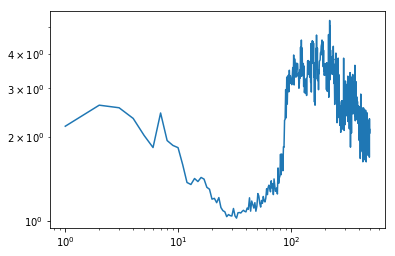

In [58]:
plt.loglog(f,np.std(spg_,axis=1)/np.mean(spg_,axis=1))

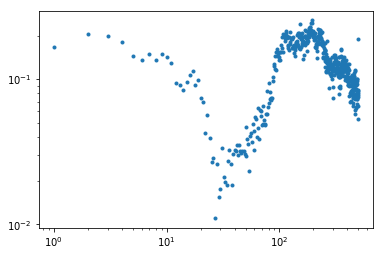

In [81]:
#lambda
_ = plt.loglog(statistics,'.')

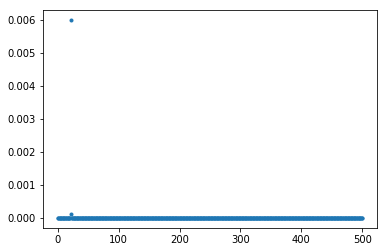

In [58]:
#lambda without loglog
_ = plt.plot(pvals,'.')

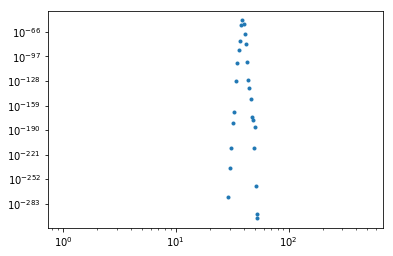

In [114]:
#lambda with loglog
_ = plt.loglog(pvals,'.')

#### chicken scratch work

(array([  2.22946313e-03,   5.01271154e-05,   1.49187843e-05,
          3.58050824e-06,   1.19350275e-06,   5.96751374e-07,
          0.00000000e+00,   0.00000000e+00,   5.96751374e-07,
          1.19350275e-06]),
 array([  1.91211291e-09,   4.34467139e+02,   8.68934277e+02,
          1.30340142e+03,   1.73786855e+03,   2.17233569e+03,
          2.60680283e+03,   3.04126997e+03,   3.47573711e+03,
          3.91020425e+03,   4.34467139e+03]),
 <a list of 10 Patch objects>)

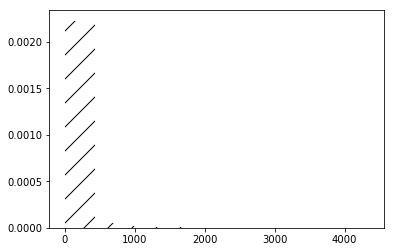

In [103]:
x = spg_[0]
param = sp.stats.expon.fit(x)
plt.hist(x, normed=True, color='white', hatch='/')